### Investigation into High-Frequency Features and Targets

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4095405


In [1]:
! pip install ruptures

import ruptures as rpt  # our package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR, ccf
import sys
import os
import logging

from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from collections import deque


sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

# Generate Features 

### Book Features
- Bid-Ask Spread (Variations)
- LOB Imbalance
- Midprice Returns

### Trade Features
- Roll Measure ( covariance of returns )
- Order Size Volume (Variations)
- Kyle's Lambda  (Variations)
- Order Size Imbalance
- Order Side Imbalance
- VPIN /PIN

### Targets
- Bid-Ask Spread (Variations)
- Returns (Sign and Size)
- Transaction Duration

In [ ]:
# Choose some features
features_to_load = [
    "spread_mean",
    "midprice_mean",
    "bbo_imbalance_mean",
    'trade_side_mean',# order side imbalance
    'trade_count',
    "Volume", # dollar volume
]

# Last 2 weeks
end = datetime.strptime("2022-8-2","%Y-%m-%d")
start= datetime.strptime("2022-5-1","%Y-%m-%d")

# Choose buckketing
time_agg = "5sec" # 1sec/5sec/10sec/30sec/60sec

df_data = load_features(
    "ftx", "BTCUSDP", time_agg, start, end, features_to_load
)
df_data.columns=[str(i+"_5") for i in df_data.columns]
df_data['Returns_5']=np.zeros(df_data.shape[0]) # many of these are zero as price doesn't always shift -> leads to illdefined correlations 
df_data['Returns_5']=pd.Series(df_data['midprice_mean_5'].pct_change(),index=df_data.index[1:])*100
df_data['Lambda_5']=df_data['Returns_5']/df_data['Volume_5'] # 5 second lookback which is our default here 

  
df_data['Roll_30']=2*np.sqrt(df_data['Returns_5'].rolling(6).cov(df_data['Returns_5'].shift(1).rolling(6)))
df_data

### Generate Targets -> 5/30 Seconds
Transaction Return 
- The average return of midprices over a future window

Price Direction
- Binary variable relating future window of returns to current (avg)

Transaction Duration (TO:DO)
- Amount of time required for some value of transactions/volume etc. to transact 


In [ ]:
df_data['Target_Return_5']=df_data['Returns_5'].shift(-1)
df_data['Target_Return_30']=df_data['Returns_5'].shift(-6)

df_data['Target_Price_Dir5']=(df_data['Target_Return_5']>df_data['Returns_5'].mean()).astype(int)

df_data['Target_Price_Dir30']=(df_data['Target_Return_30']>df_data['Returns_5'].mean()).astype(int)

In [3]:
#df_data.to_csv('lasso_cpd.csv')
df_data=pd.read_csv('/home/jovyan/personal/Changepoint_LOB/lassoeth__cpd.csv')

In [4]:
df_data

,timestamp,exchange_5,symbol_5,spread_mean_5,midprice_mean_5,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30,Target_Return_5,Target_Return_30,Target_Price_Dir5,Target_Price_Dir30,date
0,2022-05-01 00:01:00+00:00,ftx,ETHUSDP,0.120196,2728.320969,0.490576,0.250000,12.0,17.464000,-0.005073,-0.000290,0.014746,-0.042583,-0.000872,0,0,2022-05-01
1,2022-05-01 00:01:05+00:00,ftx,ETHUSDP,0.118438,2727.159155,0.234865,0.666667,27.0,37.243000,-0.042583,-0.001143,0.021189,-0.000421,-0.000056,0,0,2022-05-01
2,2022-05-01 00:02:00+00:00,ftx,ETHUSDP,0.134055,2729.142710,0.755301,0.112782,133.0,266.844998,0.076726,0.000288,0.030211,0.035066,0.015194,1,1,2022-05-01
3,2022-05-01 00:02:05+00:00,ftx,ETHUSDP,0.106863,2730.099703,0.682266,0.566667,30.0,17.233000,0.035066,0.002035,0.042454,-0.019230,0.018209,0,1,2022-05-01
4,2022-05-01 00:02:10+00:00,ftx,ETHUSDP,0.109980,2729.574702,0.522063,0.850000,20.0,8.994000,-0.019230,-0.002138,0.029575,-0.014925,0.015792,0,1,2022-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752354,2022-08-01 23:59:00+00:00,ftx,ETHUSDP,0.100806,1633.072562,0.117805,1.000000,18.0,21.374000,-0.010864,-0.000508,0.006477,-0.013644,-0.066089,0,0,2022-08-01
752355,2022-08-01 23:59:05+00:00,ftx,ETHUSDP,0.100671,1632.849750,0.089403,1.000000,11.0,6.150000,-0.013644,-0.002218,0.015814,-0.012563,0.001815,0,1,2022-08-01
752356,2022-08-01 23:59:10+00:00,ftx,ETHUSDP,0.101166,1632.644622,0.115961,0.958333,24.0,23.705000,-0.012563,-0.000530,0.014699,-0.005793,0.001778,0,1,2022-08-01
752357,2022-08-01 23:59:15+00:00,ftx,ETHUSDP,0.099976,1632.550049,0.156325,0.800000,5.0,0.417000,-0.005793,-0.013891,0.010102,-0.003896,-0.016909,0,0,2022-08-01


# Fit a Penalized LASSO Model with cross validated alpha value for each target 

Note we are fitting the penalized model across our entire dataset, this is okay as we are not assessing predictability but instead analyzing an empirical relationship

For each target we first standardize our feature set via normalization 

We then apply cross validation to optimally tune a LASSO model for each target

### Mean Return 5 seconds into Future

In [5]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

coeff_df=pd.DataFrame()

In [6]:
features= [ "bbo_imbalance_mean_5","trade_side_mean_5","trade_count_5","Volume_5","Returns_5","Lambda_5","Roll_30"] # All are 5 second lookback except for Roll -> Requires correlation on window 
targets=["Target_Return_5","Target_Return_30","Target_Price_Dir5","Target_Price_Dir30"]

In [7]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Return_5'],train_size=0.99,random_state=100)

In [8]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
339581,0.734338,0.093750,64.0,107.579,-0.037295,-0.000347,0.039897
655796,0.381309,0.526316,19.0,9.012,-0.046959,-0.005211,0.033104
582829,0.276217,0.847826,46.0,101.553,-0.031712,-0.000312,0.040526
370881,0.454507,0.659574,47.0,92.182,0.001443,0.000016,0.038562
333204,0.681663,0.923077,13.0,27.189,-0.003676,-0.000135,0.008959
...,...,...,...,...,...,...,...
718730,0.490943,0.750000,4.0,1.251,0.002125,0.001698,0.042968
212912,0.612472,0.909091,11.0,69.270,-0.017368,-0.000251,0.005350
65615,0.424272,1.000000,4.0,1.955,-0.017071,-0.008732,0.019849
210755,0.229023,0.880000,25.0,25.677,-0.042978,-0.001674,0.013257


Let's normalize our data s.t. no individual feature overflows /skews the penalty 

This is very important in LASSO, otherwise it is possible for a noniformative feature to "drown" out informative features soley on magnitudes 

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [10]:
model= linear_model.LassoCV( ) # here we use cross validated LASSO
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [11]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[0]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.08102299121269382 
trade_side_mean_5 best estimate is -0.22122101072605657 
trade_count_5 best estimate is 0.002511623358953183 
Volume_5 best estimate is 0.015579793678729213 
Returns_5 best estimate is 0.14082831752414404 
Lambda_5 best estimate is -0.007424761649714358 
Roll_30 best estimate is -0.010604805063563117 


In [12]:
model.alpha_

0.0011054663182221943

### Mean Return 30 Seconds into Future

In [13]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Return_30'],train_size=0.99,random_state=100)

In [14]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
339581,0.734338,0.093750,64.0,107.579,-0.037295,-0.000347,0.039897
655796,0.381309,0.526316,19.0,9.012,-0.046959,-0.005211,0.033104
582829,0.276217,0.847826,46.0,101.553,-0.031712,-0.000312,0.040526
370881,0.454507,0.659574,47.0,92.182,0.001443,0.000016,0.038562
333204,0.681663,0.923077,13.0,27.189,-0.003676,-0.000135,0.008959
...,...,...,...,...,...,...,...
718730,0.490943,0.750000,4.0,1.251,0.002125,0.001698,0.042968
212912,0.612472,0.909091,11.0,69.270,-0.017368,-0.000251,0.005350
65615,0.424272,1.000000,4.0,1.955,-0.017071,-0.008732,0.019849
210755,0.229023,0.880000,25.0,25.677,-0.042978,-0.001674,0.013257


In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [16]:
model= linear_model.LassoCV( ) # here use an alpha penalty of 0.01
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [17]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[1]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.0032390235925456173 
trade_side_mean_5 best estimate is -0.0011107680383962177 
trade_count_5 best estimate is 0.00310408205707817 
Volume_5 best estimate is 0.0 
Returns_5 best estimate is -0.007717049169133272 
Lambda_5 best estimate is 0.0 
Roll_30 best estimate is -0.008192456738541886 


In [18]:
model.alpha_

0.0010620658800430563

### Binary Price Direction of Mean Return 5 Seconds into Future

In [19]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Price_Dir5'],train_size=0.99,random_state=100)

In [20]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
339581,0.734338,0.093750,64.0,107.579,-0.037295,-0.000347,0.039897
655796,0.381309,0.526316,19.0,9.012,-0.046959,-0.005211,0.033104
582829,0.276217,0.847826,46.0,101.553,-0.031712,-0.000312,0.040526
370881,0.454507,0.659574,47.0,92.182,0.001443,0.000016,0.038562
333204,0.681663,0.923077,13.0,27.189,-0.003676,-0.000135,0.008959
...,...,...,...,...,...,...,...
718730,0.490943,0.750000,4.0,1.251,0.002125,0.001698,0.042968
212912,0.612472,0.909091,11.0,69.270,-0.017368,-0.000251,0.005350
65615,0.424272,1.000000,4.0,1.955,-0.017071,-0.008732,0.019849
210755,0.229023,0.880000,25.0,25.677,-0.042978,-0.001674,0.013257


In [21]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [22]:
model= linear_model.LassoCV( ) # here use an alpha penalty of 0.01
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [23]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[2]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.18088621798177504 
trade_side_mean_5 best estimate is -0.31714853075638827 
trade_count_5 best estimate is -0.062489003669639845 
Volume_5 best estimate is 0.03439675451471276 
Returns_5 best estimate is 0.015842854721785173 
Lambda_5 best estimate is -0.0031358391865055992 
Roll_30 best estimate is -0.037264478241882816 


In [24]:
model.alpha_

0.0003874542153440933

### Binary Price Direction of Mean Return 30 Seconds into Future 

In [25]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Price_Dir30'],train_size=0.99,random_state=100)

In [26]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
339581,0.734338,0.093750,64.0,107.579,-0.037295,-0.000347,0.039897
655796,0.381309,0.526316,19.0,9.012,-0.046959,-0.005211,0.033104
582829,0.276217,0.847826,46.0,101.553,-0.031712,-0.000312,0.040526
370881,0.454507,0.659574,47.0,92.182,0.001443,0.000016,0.038562
333204,0.681663,0.923077,13.0,27.189,-0.003676,-0.000135,0.008959
...,...,...,...,...,...,...,...
718730,0.490943,0.750000,4.0,1.251,0.002125,0.001698,0.042968
212912,0.612472,0.909091,11.0,69.270,-0.017368,-0.000251,0.005350
65615,0.424272,1.000000,4.0,1.955,-0.017071,-0.008732,0.019849
210755,0.229023,0.880000,25.0,25.677,-0.042978,-0.001674,0.013257


In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [28]:
model= linear_model.LassoCV( ) # here use an alpha penalty of 0.01
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [29]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[3]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.008065549034159491 
trade_side_mean_5 best estimate is -0.0031116969328799527 
trade_count_5 best estimate is -0.04333051251552109 
Volume_5 best estimate is 0.02475885775754166 
Returns_5 best estimate is -0.0004146654985903311 
Lambda_5 best estimate is 9.317001718344484e-05 
Roll_30 best estimate is -0.043124481768719025 


In [30]:
model.alpha_

0.00012564607617512733

# Results 

### LASSO with cross validated optimal alpha 

In [31]:
coeff_df=coeff_df.T
coeff_df.columns=features
coeff_df.index=targets

In [32]:
sig_coeff_df=coeff_df[abs(coeff_df)>0.01].fillna(0)
sig_coeff_df

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
Target_Return_5,0.081023,-0.221221,0.000000,0.015580,0.140828,0.0,-0.010605
Target_Return_30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Target_Price_Dir5,0.180886,-0.317149,-0.062489,0.034397,0.015843,0.0,-0.037264
Target_Price_Dir30,0.000000,0.000000,-0.043331,0.024759,0.000000,0.0,-0.043124


### Daily Ordinary Least Squares Model for significant variables 

We are particularly interested to see if there is a changepoint pattern across optimal betas 

This would support our results about changes between empirical relationships

In [33]:
sig_features={}
for x,row in sig_coeff_df.iterrows():
    
    sig_features[x]=row[abs(row)>0.01].index.values
    
sig_features

{'Target_Return_5': array(['bbo_imbalance_mean_5', 'trade_side_mean_5', 'Volume_5',
        'Returns_5', 'Roll_30'], dtype=object),
 'Target_Return_30': array([], dtype=object),
 'Target_Price_Dir5': array(['bbo_imbalance_mean_5', 'trade_side_mean_5', 'trade_count_5',
        'Volume_5', 'Returns_5', 'Roll_30'], dtype=object),
 'Target_Price_Dir30': array(['trade_count_5', 'Volume_5', 'Roll_30'], dtype=object)}

In [34]:
#df_data['date']=[i.date() for i in df_data.index]
days=np.unique(np.array([i  for i in df_data['date']]))

coeff={}
for j in sig_features.keys(): 
    if len(sig_features[j])==0:
        continue
    coeff[j]=np.array([])
    for i in days:
    
        subset=df_data[df_data['date']==i]
        
        X_train, X_test, y_train, y_test =train_test_split(subset[sig_features[j]],subset[j],train_size=0.99,random_state=100)
        model=linear_model.LinearRegression()
        model.fit(X_train,y_train)
        
        coeff[j]=np.append(coeff[j],np.array(model.coef_))

### Mean Return 5 seconds into Future

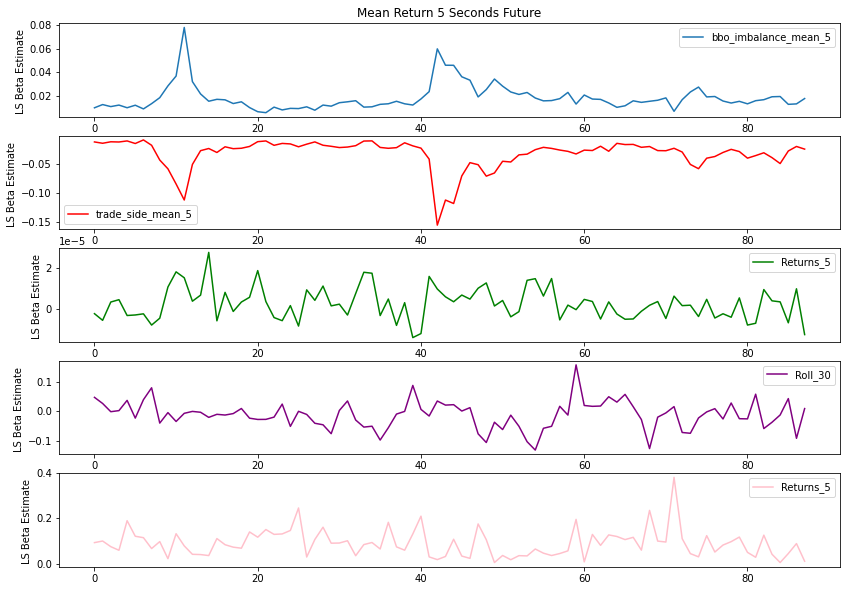

In [41]:
mean_return_beta=pd.DataFrame(coeff['Target_Return_5'].reshape(88,5),columns=sig_features['Target_Return_5'])
fig,ax=plt.subplots(5,1,figsize=(14,10))
ax[0].set_title("Mean Return 5 Seconds Future")
ax[0].plot(mean_return_beta['bbo_imbalance_mean_5'],label='bbo_imbalance_mean_5')
ax[1].plot(mean_return_beta['trade_side_mean_5'],color='red',label='trade_side_mean_5')
ax[2].plot(mean_return_beta['Volume_5'],color='green',label='Returns_5')
ax[3].plot(mean_return_beta['Roll_30'],color='purple',label='Roll_30')
ax[4].plot(mean_return_beta['Returns_5'],color='pink',label='Returns_5')
ax[0].set_xlabel("May-August 2022")
ax[1].set_xlabel("May-August 2022")
ax[2].set_xlabel("May-August 2022")
ax[0].set_ylabel("LS Beta Estimate ")
ax[1].set_ylabel("LS Beta Estimate ")
ax[2].set_ylabel("LS Beta Estimate ")
ax[3].set_ylabel("LS Beta Estimate ")
ax[4].set_ylabel("LS Beta Estimate ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()

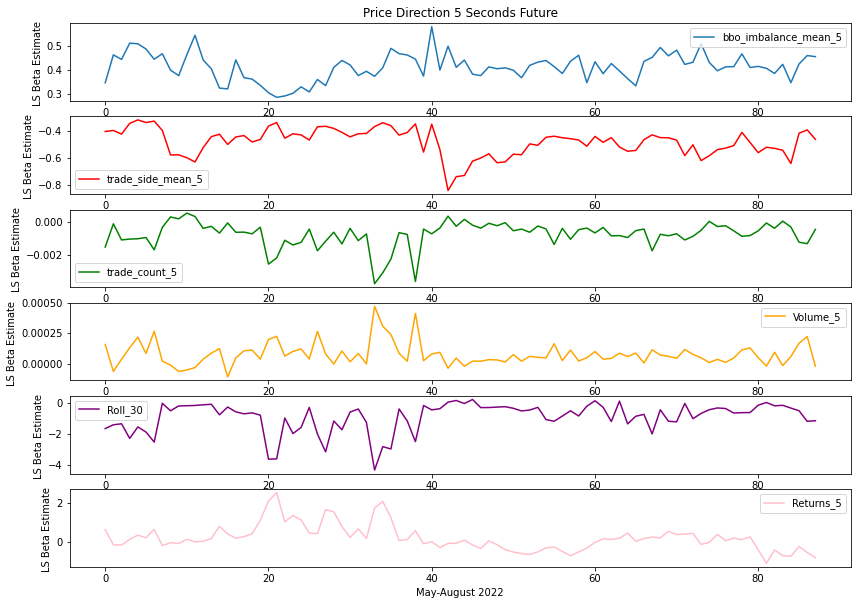

In [42]:
mean_dir_return_beta=pd.DataFrame(coeff['Target_Price_Dir5'].reshape(88,6),columns=sig_features['Target_Price_Dir5'])

fig,ax=plt.subplots(6,1,figsize=(14,10))
ax[0].set_title("Price Direction 5 Seconds Future")
ax[0].plot(mean_dir_return_beta['bbo_imbalance_mean_5'],label='bbo_imbalance_mean_5')
ax[1].plot(mean_dir_return_beta['trade_side_mean_5'],color='red',label='trade_side_mean_5')
ax[2].plot(mean_dir_return_beta['trade_count_5'],color='green',label='trade_count_5')
ax[3].plot(mean_dir_return_beta['Volume_5'],color='orange',label='Volume_5')
ax[4].plot(mean_dir_return_beta['Roll_30'],color='purple',label='Roll_30')
ax[5].plot(mean_dir_return_beta['Returns_5'],color='pink',label='Returns_5')

ax[5].set_xlabel("May-August 2022")
ax[0].set_ylabel("LS Beta Estimate ")
ax[1].set_ylabel("LS Beta Estimate ")
ax[2].set_ylabel("LS Beta Estimate ")
ax[3].set_ylabel("LS Beta Estimate ")
ax[4].set_ylabel("LS Beta Estimate ")
ax[5].set_ylabel("LS Beta Estimate ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()

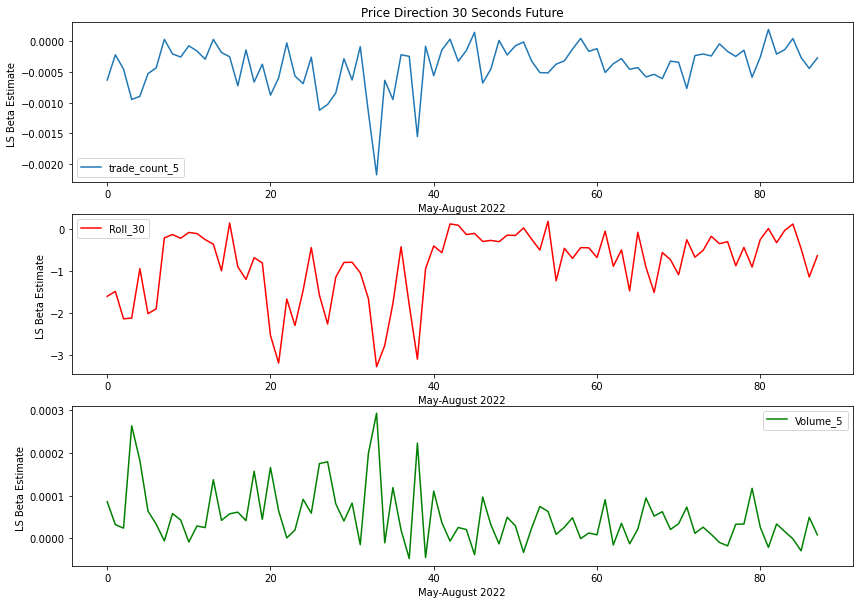

In [40]:
price_dir_30_beta=pd.DataFrame(coeff['Target_Price_Dir30'].reshape(88,3),columns=sig_features['Target_Price_Dir30'])
fig,ax=plt.subplots(3,1,figsize=(14,10))
ax[0].set_title("Price Direction 30 Seconds Future")
ax[0].plot(price_dir_30_beta['trade_count_5'],label='trade_count_5')
ax[1].plot(price_dir_30_beta['Roll_30'],color='red',label='Roll_30')
ax[2].plot(price_dir_30_beta['Volume_5'],color='green',label='Volume_5')
ax[0].set_xlabel("May-August 2022")
ax[1].set_xlabel("May-August 2022")
ax[2].set_xlabel("May-August 2022")
ax[0].set_ylabel("LS Beta Estimate ")
ax[1].set_ylabel("LS Beta Estimate ")
ax[2].set_ylabel("LS Beta Estimate "
ax[0].legend()
ax[1].legend()
ax[2].legend()


### Changepoint Analysis 

We will be implementing Pruned Linear Exact Time (PELT) to detect changepoints linearly in time via a pruning step where our cost function is mse and 

Cross-Validation needs to be applied to tune the penalty coeficient 


In [44]:
def compute_cp(signal,pen,min_size,jump):
    model = "l2"  # mse cost between observed 
    algo = rpt.Pelt(model=model, min_size=min_size, jump=jump).fit(signal.values)
    for pen in np.linspace(1,10,10):
        my_bkps = algo.predict(pen=pen)
        for i in my_bkps:
            if i==len(signal):
                my_bkps=[]
            else:
                break
            
    return my_bkps

In [45]:
features=[mean_return_beta['bbo_imbalance_mean_5'],mean_return_beta['Returns_5'],mean_return_beta['trade_side_mean_5'],mean_return_beta['Volume_5'],mean_return_beta['Roll_30'],mean_dir_return_beta['bbo_imbalance_mean_5'],mean_dir_return_beta['trade_side_mean_5'],mean_dir_return_beta['trade_count_5'],mean_dir_return_beta['Volume_5'],mean_dir_return_beta['Roll_30'],mean_dir_return_beta['Returns_5'],price_dir_30_beta['trade_count_5'],price_dir_30_beta['Volume_5'],price_dir_30_beta['Roll_30']]
pen=1
min_size=5 # 5 days between changepoints
jump=1 # every candidate point is considered 

bkps_feat={}
for j,i in enumerate(features):
    bkps=compute_cp(i,pen,min_size,jump)
    bkps_feat[str(i.name+f"_{j}")]=np.array(bkps)
    if len(bkps)>0:
        print(i.name,j,bkps)

Roll_30 9 [20, 39, 88]
Returns_5 10 [36, 88]
Roll_30 13 [40, 88]


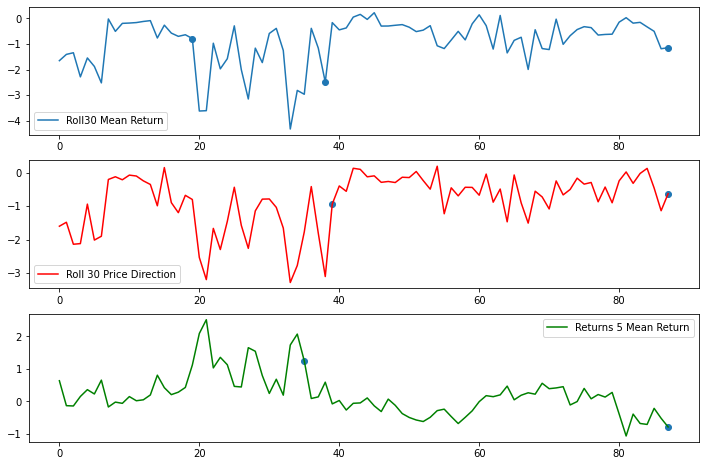

In [51]:
fig,ax=plt.subplots(3,1,figsize=(12,8))
ax[0].plot(mean_dir_return_beta['Roll_30'],label='Roll30 Mean Return')
ax[0].scatter(mean_dir_return_beta.index[bkps_feat['Roll_30_9']-1],mean_dir_return_beta['Roll_30'].values[bkps_feat['Roll_30_9']-1])
ax[0].legend()
ax[1].plot(price_dir_30_beta['Roll_30'],color='red',label='Roll 30 Price Direction')
ax[1].scatter(price_dir_30_beta.index[bkps_feat['Roll_30_13']-1],price_dir_30_beta['Roll_30'].values[bkps_feat['Roll_30_13']-1])
ax[1].legend()
ax[2].plot(mean_dir_return_beta['Returns_5'],color='green',label='Returns 5 Mean Return')
ax[2].scatter(mean_dir_return_beta.index[bkps_feat['Returns_5_10']-1],mean_dir_return_beta['Returns_5'].values[bkps_feat['Returns_5_10']-1])
ax[2].legend()
